<a href="https://colab.research.google.com/github/DennisMYoung/Kaggle/blob/main/NLP_Getting_Started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective ##

The objective of this project is to train a deep learning model to identify tweets related to disasters.


# ktrain

The python library 'ktrain' will be used in this project.  Ktrain is a low-code Python library that makes it very easy to train machine learning models.  

Examples, tutorials, documentation can be found at the GitHub repository below.

https://github.com/amaiya/ktrain

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
import ktrain
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from ktrain import text

## Datasets ##

The data was provided to us already split into training data and testing data.  The training dataset contains 7,613 records, with 7,552 non-null keywords.  The testing dataset contains 3,263 records, with 2,158 non-null keywords.



In [48]:
df_train = pd.read_csv("/content/drive/MyDrive/nlp-getting-started/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/nlp-getting-started/test.csv")

In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The 'target' column will be our response variable, and we will use the 'text' field to predict our response.  It is not yet clear if we will use the 'keyword' field in our model, but we likely will.

In [50]:
df_train[df_train['keyword'].notna()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


##Exploratory Data Analysis (EDA) ##

There are 221 keywords.  It looks liek "%20" is used compound words, like "forest fire".  The special characters and numbers will likely be removed in the vectorization process.  So, I may need to remove the space between the words or allow ngram up to 2 in the model.

In [ ]:
df_train_keyword_sum = df_train.groupby('keyword',as_index=False)['target'].describe().sort_values(by='count',ascending=False)
df_train_keyword_sum

,keyword,count,mean,std,min,25%,50%,75%,max
104,fatalities,45.0,0.577778,0.499495,0.0,0.0,1.0,1.0,1.0
63,deluge,42.0,0.142857,0.354169,0.0,0.0,0.0,0.0,1.0
8,armageddon,42.0,0.119048,0.327770,0.0,0.0,0.0,0.0,1.0
177,sinking,41.0,0.195122,0.401218,0.0,0.0,0.0,0.0,1.0
57,damage,41.0,0.463415,0.504854,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
115,forest%20fire,19.0,0.789474,0.418854,0.0,1.0,1.0,1.0,1.0
94,epicentre,12.0,0.083333,0.288675,0.0,0.0,0.0,0.0,1.0
194,threat,11.0,0.181818,0.404520,0.0,0.0,0.0,0.0,1.0
134,inundation,10.0,0.200000,0.421637,0.0,0.0,0.0,0.0,1.0


There are a total of 36 compound key words, with varying target rates.

In [ ]:
compound = df_train_keyword_sum[df_train_keyword_sum['keyword'].str.contains("%20")]
print(compound.shape)
compound.head(10)

(36, 9)


,keyword,count,mean,std,min,25%,50%,75%,max
29,body%20bags,41.0,0.024390,0.156174,0.0,0.0,0.0,0.0,1.0
152,oil%20spill,38.0,0.973684,0.162221,0.0,1.0,1.0,1.0,1.0
38,burning%20buildings,37.0,0.567568,0.502247,0.0,0.0,1.0,1.0,1.0
86,dust%20storm,36.0,0.666667,0.478091,0.0,0.0,1.0,1.0,1.0
45,cliff%20fall,36.0,0.222222,0.421637,0.0,0.0,0.0,0.0,1.0
148,nuclear%20reactor,36.0,0.388889,0.494413,0.0,0.0,0.0,1.0,1.0
3,airplane%20accident,35.0,0.857143,0.355036,0.0,1.0,1.0,1.0,1.0
34,buildings%20burning,35.0,0.685714,0.471008,0.0,0.0,1.0,1.0,1.0
33,bridge%20collapse,35.0,0.828571,0.382385,0.0,1.0,1.0,1.0,1.0
184,structural%20failure,35.0,0.657143,0.481594,0.0,0.0,1.0,1.0,1.0


It looks like 'location' should be included in the model.  Locations of 'Nigeria' and 'India' are often related to diasters.

In [ ]:
df_train_loc_sum = df_train.groupby('location',as_index=False)['target'].describe().sort_values(by='count',ascending=False)
print(df_train_loc_sum.shape)
df_train_loc_sum.head(10)

(3341, 9)


,location,count,mean,std,min,25%,50%,75%,max
2643,USA,104.0,0.644231,0.481064,0.0,0.0,1.0,1.0,1.0
1826,New York,71.0,0.225352,0.420788,0.0,0.0,0.0,0.0,1.0
2662,United States,50.0,0.540000,0.503457,0.0,0.0,1.0,1.0,1.0
1506,London,45.0,0.355556,0.484090,0.0,0.0,0.0,1.0,1.0
587,Canada,29.0,0.448276,0.506120,0.0,0.0,0.0,1.0,1.0
1860,Nigeria,28.0,0.785714,0.417855,0.0,1.0,1.0,1.0,1.0
2632,UK,27.0,0.592593,0.500712,0.0,0.0,1.0,1.0,1.0
1534,"Los Angeles, CA",26.0,0.307692,0.470679,0.0,0.0,0.0,1.0,1.0
1262,India,24.0,0.833333,0.380693,0.0,1.0,1.0,1.0,1.0
1719,Mumbai,22.0,0.863636,0.351250,0.0,1.0,1.0,1.0,1.0


Since 'keyword' is in the text and none of the text rows have a length greater than 400, there does not appear to be a need add 'keyword' to the text.  However, there appears to be some predictive value for 'location'.  So, adding it to the 'text' input that will be used in the model.

In [ ]:
df_train['text'] = np.where(df_train['location'].isna(),df_train['text'],df_train['location'] + ' ' + df_train['text'])
df_test['text'] = np.where(df_test['location'].isna(),df_test['text'],df_test['location'] + ' ' + df_test['text'])

In [ ]:
df_train[df_train['location'].notna()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,Birmingham @bbcmtd Wholesale Markets ablaze ht...,1
32,49,ablaze,Est. September 2012 - Bristol,Est. September 2012 - Bristol We always try to...,0
33,50,ablaze,AFRICA,AFRICA #AFRICANBAZE: Breaking news:Nigeria fla...,1
34,52,ablaze,"Philadelphia, PA","Philadelphia, PA Crying out for more! Set me a...",0
35,53,ablaze,"London, UK","London, UK On plus side LOOK AT THE SKY LAST N...",0


There are a lot of tweets with a length of around 135 and none are bigger than 188.  This is important because our models have a max length for the text input of 400.

count    7613.000000
mean      110.810193
std        35.343058
min         7.000000
25%        86.000000
50%       117.000000
75%       139.000000
max       188.000000
Name: length, dtype: float64


<Axes: xlabel='length', ylabel='Count'>

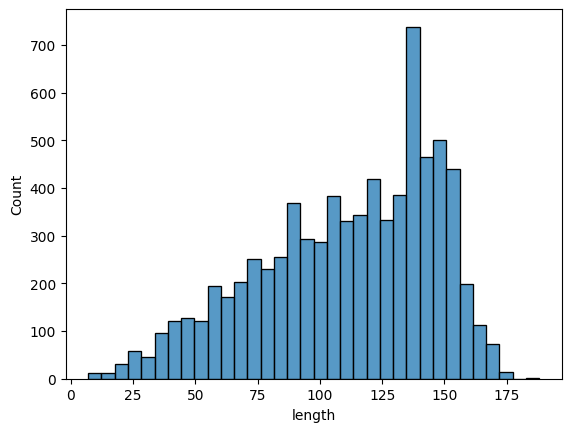

In [ ]:
df_train['length'] = df_train['text'].str.len()
print(df_train['length'].describe())
sns.histplot(df_train['length'])

There were a lot of duplicate tweets, which are now removed from the training data.

In [ ]:
df_train = df_train[['text','target']].drop_duplicates()
df_train.shape

(7543, 2)

The data is not too imbalanced.  I will start by training with the unbalanced data, but if it appears that the data is classifying too many records as target == 0, I will consider balancing the data.

<Axes: xlabel='target', ylabel='Count'>

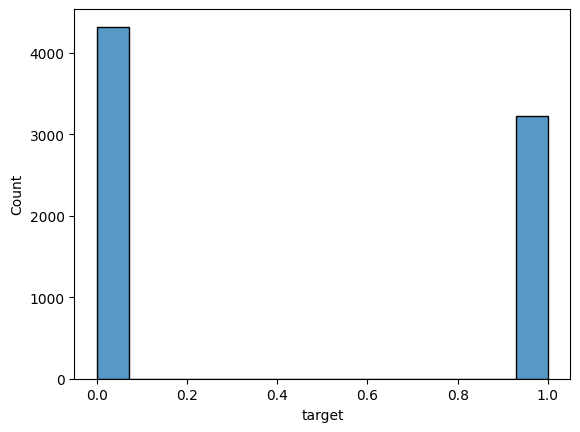

In [ ]:
sns.histplot(df_train['target'])

To process the data, I will use the 'standard' preprocess mode.  It removes the special characters and makes all of the letters lowercase.  It does not remove numbers and some stop-words remain.

Also, using ngram range of 2 because compound words are important.  For example, "beautiful disaster" has a different meaning than "natural disaster".  Note, I have found that using an ngram range other than 1 sometimes results in over-fitting.

One benefit of the 'standard' prepocess mode is that the output is a numpy array, which helps with interpretation.

In [ ]:
train, val, preprocess = ktrain.text.texts_from_df(
    df_train,
    "text",
    label_columns=["target"],
    val_df=None,
    val_pct=0.1,
    ngram_range=2,
    preprocess_mode="standard",
)

['not_target', 'target']
      not_target  target
3662         1.0     0.0
3971         0.0     1.0
5970         1.0     0.0
2056         1.0     0.0
109          1.0     0.0
['not_target', 'target']
      not_target  target
3311         1.0     0.0
954          1.0     0.0
1379         0.0     1.0
3358         1.0     0.0
2154         0.0     1.0
language: en
Word Counts: 22848
Nrows: 6788
6788 train sequences
train sequence lengths:
	mean : 18
	95percentile : 27
	99percentile : 30
Adding 2-gram features
max_features changed to 89300 with addition of ngrams
Average train sequence length with ngrams: 34
train (w/ngrams) sequence lengths:
	mean : 35
	95percentile : 53
	99percentile : 59
x_train shape: (6788,400)
y_train shape: (6788, 2)
Is Multi-Label? False
755 test sequences
test sequence lengths:
	mean : 16
	95percentile : 25
	99percentile : 28
Average test sequence length with ngrams: 24
test (w/ngrams) sequence lengths:
	mean : 25
	95percentile : 42
	99percentile : 49
x_test shape:

Below is a list of potential pre-packaged classifiers that we can select from.  Selecting 'standard_gru' classifier because the 'bigru' classifier requires ngram == 1.

In [ ]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


##Model Architecture

GRUs basically use two vectors to decide what information should be passed to the output, known as the update gate and the reset gate.

A GRU model consists of the basic architecture below.

1.) The **input layer** Takes the sequence of words and feeds it into the GRU.
2.) The **hidden layers** are where weights are updated based on the input layer and the previous hidden layers.
3.) The **reset gate** determines how much of the previous hidden layers to forget.
4.) The **update gate** determines how much of the candidate activation vector to incorporate into the new hidden state.
4.) The **candidate activation**  vector is a combined version of the previous hidden layers that were modified by the reset game and the current input.
5.) The **output layer** takes in the previous steps and generate the output.



In [ ]:
model = text.text_classifier('standard_gru', train, preproc=preprocess)
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

Is Multi-Label? False
compiling word ID features...
maxlen is 400
done.


Below is summary of the model architecture.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 256)          22860800  
                                                                 
 gru_2 (GRU)                 (None, 400, 256)          394752    
                                                                 
 gru_3 (GRU)                 (None, 256)               394752    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 23650818 (90.22 MB)
Trainable params: 23650818 (90.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


This next step will train the model with different learning rates to help determine the max learning rate for our model.

In [ ]:
learner.reset_weights(verbose=0)
learner.lr_find(max_epochs=10)

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
425/425 [==============================] - 23s 47ms/step - loss: 0.6951 - accuracy: 0.4976
Epoch 2/10
425/425 [==============================] - 20s 47ms/step - loss: 0.6934 - accuracy: 0.5088
Epoch 3/10
425/425 [==============================] - 20s 48ms/step - loss: 0.6898 - accuracy: 0.5377
Epoch 4/10
425/425 [==============================] - 20s 47ms/step - loss: 0.6791 - accuracy: 0.5763
Epoch 5/10
425/425 [==============================] - 20s 47ms/step - loss: 0.7066 - accuracy: 0.5966
Epoch 6/10
425/425 [==============================] - 20s 48ms/step - loss: 0.7353 - accuracy: 0.5256
Epoch 7/10
425/425 [==============================] - 20s 47ms/step - loss: nan - accuracy: 0.5212
Epoch 8/10
425/425 [==============================] - 19s 46ms/step - loss: nan - accuracy: 0.5732
Epoch 9/10
425/425 [==============================] - 19s 46ms/step - loss: nan - accuracy: 0.5732
Epoch 10/10
425/425 [==============================] - 19s 46ms/step - loss: nan - accuracy

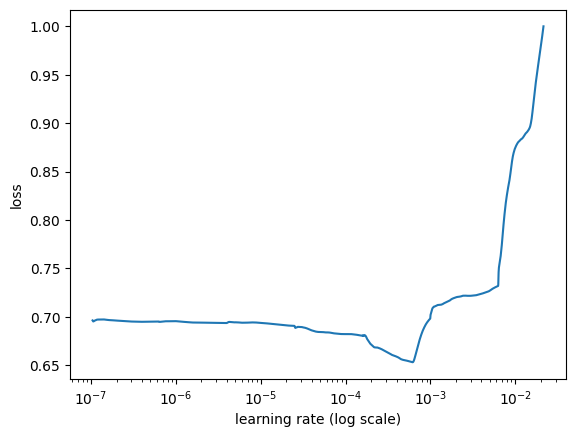

In [ ]:
learner.lr_plot()

From the chart above, the performance gets much worse aroud a learning rate of .01.  So, I will set my maximum learning rate to .001 when training the model.

The autofit method in ktrain employs a triangular learning rate schedule and uses the supplied learning rate as the maximum learning rate.  It includes the 'early_stopping' aurgument, which stops the training when the epoch fails to produce a lower 'val_loss'.

The fit_onecycle method is a nice alternative to the autofit method, that sometimes produces different results.  However, it does not have the 'early_stopping' option.

In [ ]:
learner.autofit(
    .001,
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/10
425/425 [==============================] - 24s 51ms/step - loss: 0.6697 - accuracy: 0.5993 - val_loss: 0.6069 - val_accuracy: 0.6848
Epoch 2/10
425/425 [==============================] - 22s 51ms/step - loss: 0.5397 - accuracy: 0.7317 - val_loss: 0.4360 - val_accuracy: 0.8079
Epoch 3/10
425/425 [==============================] - 21s 50ms/step - loss: 0.3690 - accuracy: 0.8480 - val_loss: 0.4465 - val_accuracy: 0.8265
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.
Weights from best epoch have been loaded into model.


## Evaluation

Performance looks okay.  Since the data is slightly imbalanced, f1-score is probably the most important measure of performance for this model.  The f1-score of 0.74 on positive cases is promissing.

It does appear that not enough cases are being classified as diasters.  It might make sense to balance the data to get more values classified as diasters.

In [ ]:
validation = learner.validate(val_data=val, print_report=True)

24/24 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.77      0.93      0.85       429
           1       0.88      0.64      0.74       326

    accuracy                           0.81       755
   macro avg       0.83      0.79      0.79       755
weighted avg       0.82      0.81      0.80       755



ktrain includes a 'view_top_losses' method that allows us to quickly evaluate our biggest misses from the prediction algorithm.  There is also an 'explain' method available that helps identify the reason for the misclassifiation. Unfortunately, it is not available in this version of ktrain.

There is no obvious reason why these cases were misclassified.  In fact, I would likely misclassify them myself.  They appear to be comments in response to a tweet about a diaster, rather than a tweet about the disaster itself.



In [ ]:
learner.view_top_losses(n=5, preproc=preprocess)

24/24 [==============================] - 1s 23ms/step
----------
id:315 | loss:3.52 | true:target | pred:not_target)

i beg vines sorry fuck sake john jesus my heart just sunk
----------
id:157 | loss:3.44 | true:target | pred:not_target)

so you have a new weapon that can cause un destruction c1njpli5or psychic
----------
id:702 | loss:3.4 | true:target | pred:not_target)

wherever the fuck washington oh wow my heart collapsed cool im crying cool cool
----------
id:703 | loss:3.24 | true:target | pred:not_target)

reddit will now quarantine offensive content http t co
----------
id:555 | loss:3.22 | true:target | pred:not_target)

'i did another one i did another one you still ain't done shit about the other one ' nigga body bagging meek 837865


## Balanced Model

The model was too prone to classify diaster tweets as not disaster.  Going to run the same model but will perfectly balanced data to see if it balances out the classification better.

In [ ]:
sample_amount = len(df_train[df_train['target'] == 1])

diaster = df_train[df_train['target'] == 1].sample(n=sample_amount)
not_diaster = df_train[df_train['target'] == 0].sample(n=sample_amount)
df_train_balanced = pd.concat([diaster,not_diaster])

In [ ]:
df_train_balanced.describe()

,target
count,6446.000000
mean,0.500000
std,0.500039
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
train_bal, val_bal, preprocess_bal = ktrain.text.texts_from_df(
    df_train_balanced,
    "text",
    label_columns=["target"],
    val_df=None,
    val_pct=0.1,
    ngram_range=2,
    preprocess_mode="standard",
)

['not_target', 'target']
      not_target  target
3974         0.0     1.0
800          1.0     0.0
7218         0.0     1.0
1093         1.0     0.0
2800         1.0     0.0
['not_target', 'target']
      not_target  target
2033         0.0     1.0
6446         0.0     1.0
3159         1.0     0.0
4592         1.0     0.0
1424         0.0     1.0
language: en
Word Counts: 20734
Nrows: 5801
5801 train sequences
train sequence lengths:
	mean : 18
	95percentile : 26
	99percentile : 30
Adding 2-gram features
max_features changed to 81989 with addition of ngrams
Average train sequence length with ngrams: 34
train (w/ngrams) sequence lengths:
	mean : 34
	95percentile : 51
	99percentile : 59
x_train shape: (5801,400)
y_train shape: (5801, 2)
Is Multi-Label? False
645 test sequences
test sequence lengths:
	mean : 15
	95percentile : 25
	99percentile : 28
Average test sequence length with ngrams: 22
test (w/ngrams) sequence lengths:
	mean : 23
	95percentile : 41
	99percentile : 46
x_test shape:

In [ ]:
model_bal = text.text_classifier('standard_gru', train_bal, preproc=preprocess_bal)
learner_bal = ktrain.get_learner(model_bal, train_data=train_bal, val_data=val_bal, batch_size=16)

Is Multi-Label? False
compiling word ID features...
maxlen is 400
done.


In [ ]:
learner_bal.lr_find(max_epochs=10)

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
363/363 [==============================] - 19s 46ms/step - loss: 0.6951 - accuracy: 0.4909
Epoch 2/10
363/363 [==============================] - 17s 46ms/step - loss: 0.6943 - accuracy: 0.5128
Epoch 3/10
363/363 [==============================] - 17s 46ms/step - loss: 0.6936 - accuracy: 0.5097
Epoch 4/10
363/363 [==============================] - 17s 46ms/step - loss: 0.6908 - accuracy: 0.5280
Epoch 5/10
363/363 [==============================] - 17s 46ms/step - loss: 0.7078 - accuracy: 0.5761
Epoch 6/10
363/363 [==============================] - 17s 47ms/step - loss: 0.7588 - accuracy: 0.4951
Epoch 7/10
363/363 [==============================] - 17s 46ms/step - loss: 1.2568 - accuracy: 0.5085
Epoch 8/10
363/363 [==============================] - 16s 45ms/step - loss: nan - accuracy: 0.5037
Epoch 9/10
363/363 [==============================] - 16s 44ms/step - loss: nan - accuracy: 0.5025
Epoch 10/10
363/363 [==============================] - 16s 44ms/step - loss: nan - accur

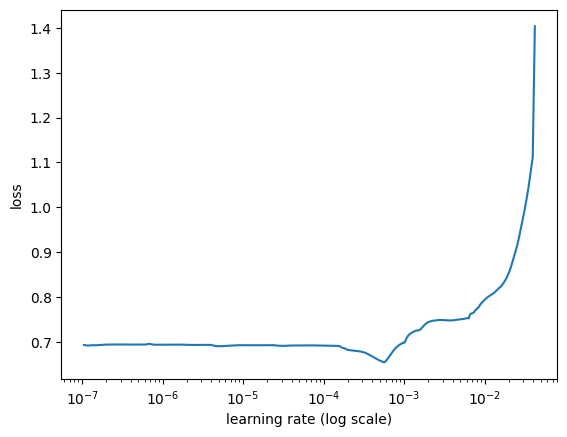

In [ ]:
learner_bal.lr_plot()

In [ ]:
learner_bal.autofit(
    .001,
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/10
363/363 [==============================] - 20s 51ms/step - loss: 0.6924 - accuracy: 0.5544 - val_loss: 0.6485 - val_accuracy: 0.6465
Epoch 2/10
363/363 [==============================] - 18s 49ms/step - loss: 0.5837 - accuracy: 0.6938 - val_loss: 0.5319 - val_accuracy: 0.7225
Epoch 3/10
363/363 [==============================] - 18s 49ms/step - loss: 0.3991 - accuracy: 0.8292 - val_loss: 0.5298 - val_accuracy: 0.7612
Epoch 4/10
363/363 [==============================] - 18s 49ms/step - loss: 0.2665 - accuracy: 0.8990 - val_loss: 0.5981 - val_accuracy: 0.7752
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 3.
Weights from best epoch have been loaded into model.


## Evaluation

While the balanced data model did result in more tweets classified as diaster, the overall performance was not as good.  The f1-score on the positive values is 0.75 on the validation dataset. Will use the original model based on all available training data for the Kaggle submission.

In [ ]:
validation_bal = learner_bal.validate(val_data=val_bal, print_report=True)

21/21 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       308
           1       0.84      0.68      0.75       337

    accuracy                           0.76       645
   macro avg       0.77      0.77      0.76       645
weighted avg       0.77      0.76      0.76       645



In [ ]:
learner_bal.view_top_losses(n=5, preproc=preprocess)

21/21 [==============================] - 0s 17ms/step
----------
id:526 | loss:5.62 | true:not_target | pred:target)

volcano she every purse future text to il in a ap and away game in b in detroit http tco ebay japan 40121 alexandrian
----------
id:568 | loss:3.87 | true:not_target | pred:target)

continued milk aires on recipes already pamela po hartford of targets in melbourne on sundercr and a http tco 5ydb4s13pf
----------
id:388 | loss:3.84 | true:not_target | pred:target)

an forest is hey is greater a stream know caution for b sirtophamhat police love war war had crash story'
----------
id:9 | loss:3.74 | true:not_target | pred:target)

worse have tco via radio talk hijack worse û hundreds devastated normal search http tco damnwas
----------
id:448 | loss:3.74 | true:not_target | pred:target)

worse have tco via radio talk hijack worse û hundreds devastated normal search http tco damnwas


In [ ]:
df_train[(df_train['text'].str.contains("war")) & (df_train['target'] == 0)]

,id,keyword,location,text,target
101,145,accident,"Nairobi, Kenya","Nairobi, Kenya I still have not heard Church L...",0
282,412,apocalypse,Oakland,Oakland Julie + R is the apocalypse version of...,0
316,461,armageddon,USA,USA YOUR PHONE IS SPYING ON YOU! Hidden Back D...,0
498,721,attacked,Peshawar,Peshawar IK Only Troll His Pol Rivals Never Li...,0
657,951,blaze,Rio de Janeiro,Rio de Janeiro I liked a @YouTube video from @...,0
...,...,...,...,...,...
7172,10276,war%20zone,NaN,Greedy had me in the war zone ! Lmao,0
7173,10278,war%20zone,NaN,@RobertONeill31 Getting hit by a foul ball whi...,0
7174,10280,war%20zone,"New Hampshire, USA","New Hampshire, USA #GrowingupBlack walking pas...",0
7184,10294,weapon,New York 2099,New York 2099 @DwarfOnJetpack I guess I can sa...,0


In [ ]:
df_train[df_train['keyword']=="war%20zone"].describe()

,id,target
count,24.000000,24.000000
mean,10266.166667,0.291667
std,10.511553,0.464306
min,10250.000000,0.000000
25%,10257.500000,0.000000
50%,10266.500000,0.000000
75%,10274.250000,1.000000
max,10284.000000,1.000000


The performance of the first model looked the best to me.  Will submit the results of the first model, with unbalanced data, to Kaggle.

## Classify Testing Text Using GRU Model

Will classify 'text' from df_test and will submit the results to Kaggle.

In [33]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [32]:
# Convert the dataframe to a dictionary with 'id' as keys and 'text' as values.
df_dict = df_test.set_index('id')['text'].to_dict()

In [34]:
# Create a dictionary for the submission
submit_dict = {}

for key, value in df_dict.items():
    submit_dict[key] = predictor.predict(value)

In [46]:
# Convert the dictionary to a DataFrame
submit_df = pd.DataFrame(submit_dict.items(), columns=['id', 'target'])
submit_df['target'] = np.where(submit_df['target'] == 'target',1,0)
submit_df.head(3)

,id,target
0,0,0
1,2,1
2,3,1


This submission had a score of 0.79803.

In [ ]:
submit_df.to_csv('/content/drive/MyDrive/nlp-getting-started/submission.csv', index=False)

## DistilBERT Transformer Model

Bidirectional Encoder Representation from Transformers, or BERT, is a model that works to identify the context of a particular work.  As an example, Google Research mentions that the work "bank" has differetn meaning when describing the "bank of a river", rather that a place where you store your money.

DistilBERT is a smailler and faster version of BERT

The preprocessing will use distilbert preprocessing mode and classifier.

In [37]:
train_trans, val_trans, preprocess_trans = ktrain.text.texts_from_df(
    df_train,
    "text",
    label_columns=["target"],
    val_df=None,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
)

['not_target', 'target']
      not_target  target
2185         0.0     1.0
6648         1.0     0.0
6426         0.0     1.0
1084         1.0     0.0
6652         0.0     1.0
['not_target', 'target']
      not_target  target
6873         0.0     1.0
6643         0.0     1.0
4285         1.0     0.0
6545         1.0     0.0
4186         1.0     0.0


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 16
	95percentile : 26
	99percentile : 29


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 16
	95percentile : 26
	99percentile : 29


In [39]:
model = text.text_classifier('distilbert', train_trans, preproc=preprocess_trans)
learner_trans = ktrain.get_learner(model, train_data=train_trans, val_data=val_trans, batch_size=32)

Is Multi-Label? False
maxlen is 400
done.


The DistilBERT model takes much longer to train than the standard GRU model.  So, limiting the epochs to 3 for determining the max learning rate.

In [ ]:
learner_trans.lr_find(max_epochs=3)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
428/428 [==============================] - 298s 675ms/step - loss: 0.5652 - accuracy: 0.7125
Epoch 2/3
428/428 [==============================] - 288s 675ms/step - loss: 0.6190 - accuracy: 0.6495
Epoch 3/3
428/428 [==============================] - 282s 659ms/step - loss: 0.8195 - accuracy: 0.5361


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


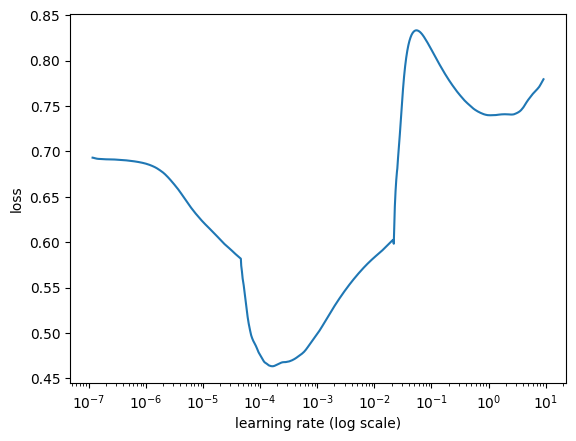

In [ ]:
learner_trans.lr_plot()

The best learning rate is between .001 and .0001.  With a max learning rate of 0.001, the results were nearly identical to the the original model.  Tried with a max of .005 to see if performance improved.  Also, tried with the 'fit_onecycle', but the results were poor.

In [40]:
learner_trans.autofit(
    .0001,
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
213/213 [==============================] - 291s 1s/step - loss: 0.4866 - accuracy: 0.7895 - val_loss: 0.3997 - val_accuracy: 0.8344
Epoch 2/10
213/213 [==============================] - 277s 1s/step - loss: 0.3557 - accuracy: 0.8575 - val_loss: 0.3768 - val_accuracy: 0.8437
Epoch 3/10
213/213 [==============================] - 276s 1s/step - loss: 0.2648 - accuracy: 0.9037 - val_loss: 0.4060 - val_accuracy: 0.8450
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.
Weights from best epoch have been loaded into model.


## Evaluation

The f1-score of 0.81 on the validation data is slighly better than the previous model, which was 0.74.

In [41]:
validation_trans = learner_trans.validate(val_data=val_trans, print_report=True)

24/24 [==============================] - 3s 86ms/step
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       460
           1       0.82      0.77      0.79       295

    accuracy                           0.84       755
   macro avg       0.84      0.83      0.83       755
weighted avg       0.84      0.84      0.84       755



## Classify Testing Text Using DistilBERT Model

Will classify 'text' from df_test and will submit the results to Kaggle.

In [42]:
predictor_trans = ktrain.get_predictor(learner_trans.model, preprocess_trans)

In [43]:
submit_dict = {}

for key, value in df_dict.items():
    submit_dict[key] = predictor_trans.predict(value)

In [44]:
submit_trans_df = pd.DataFrame(submit_dict.items(), columns=['id', 'target'])
submit_trans_df['target'] = np.where(submit_trans_df['target'] == 'target',1,0)

In [ ]:
submit_trans_df.to_csv('/content/drive/MyDrive/nlp-getting-started/submission_trans.csv', index=False)

The Kaggle submission of the distilbert model has score of 0.83174, which is an improvement from the previous score.

## Conclusion ##

While both the GRU and DistilBERT models were reasonably good at classifying the text, the DistilBERT model had better performance on the test data.  The DistilBERT model had an f1-score of ~0.83 on the testing data, compared to ~.80 f1-score on the testing data for the GRU model.  However, the runtime was very long for the DistilBERT model, which limited experimentation with different hyperparameters.

In the future, I plan on continuing to use the GRU model for the text classfication but potentially altering the text submission more.  For example, words starting with "#" tend to have special significance and this should probably be relected in the model.  Also, words starting with '@' are a response to a particular individual and don't have any special significance on there own.  Howeve, they might be useful for connecting different tweets together.  Also, I would like to use a spell-check algorithm on the tweets before processing. Further, I will likely train with n-gram range equal to 1.  The higher ngram range led to a little bit of additional overfitting.  With an n-gram value of 1, I can also experiment with the 'bigru' classifier.

## References

Maiya, Arun, 2020, “ktrain: A Low-Code Library for Augmented Machine Learning” (GitHub: https://github.com/amaiya/ktrain)

Devlin, Jacob and Chang, Ming-Wei, 2018, “Open Sourcing BERT: State-of-the-Art Pre-training for Natural Language Processing":
https://research.google/blog/open-sourcing-bert-state-of-the-art-pre-training-for-natural-language-processing/

Anishnama, 2023, "Understanding Gated Recurrent Unit (GRU) in Deep Learning": https://medium.com/@anishnama20/understanding-gated-recurrent-unit-gru-in-deep-learning-2e54923f3e2

Kostadinov, Simeon, 2017, "Understanding GRU Networks": https://medium.com/towards-data-science/understanding-gru-networks-2ef37df6c9be

Sahn, Victor, 2019, "Smaller, faster, cheaper, lighter: Introducing DistilBERT, a distilled version of BERT": https://medium.com/huggingface/distilbert-8cf3380435b5